In [1]:
import time,math,random
import itertools, collections, functools
import numpy as np
from sklearn.cluster import DBSCAN

# Visualization
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Utilities
from TurtleUtils import R, plot_fitted_garage
from robolab_turtlebot import Turtlebot, Rate
from TurtleControllers import TurtlebotController

In [2]:
class TurtlebotICP:
    def __init__(self):
        # ICP iterations
        self.max_iters = 10
        
        # Max distance, to filter out outliers
        self.threshold = 0.75
    
    def kernel(self, error):
        return 1.0 if np.linalg.norm(error) < self.threshold else 0.0
    
    def icp_svd(self, garage_model, Q):
        # ICP using SVD
        center_of_Q, Q_centered = self.center_data(Q)
        cost = None
        P_values = [garage_model.sampled.copy()]
        corresp_values = []
        exclude_indices = []
        
        def closest_point(data, point):
            delta = data - np.reshape(point, (-1, 1))
            norms = np.linalg.norm(delta, axis = 0)
            return np.min(norms)
    
        cost_angle = 0
        for i in range(self.max_iters):
            center_of_P, P_centered = self.center_data(garage_model.sampled, exclude_indices=exclude_indices)
            correspondences = self.get_correspondence_indices(P_centered, Q_centered)
            corresp_values.append(correspondences)
            cost = np.linalg.norm(P_centered - Q_centered)
            
            
            if i == self.max_iters - 1:
                g = (closest_point(P_centered, Q_centered[:,i])**2 for i in range(P_centered.shape[1]))
#                 g_minor = (closest_point(Q_centered, garage_model.corners[:,i]) * 0.0001 for i in range(4))
                cost = sum(g) #+ sum(g_minor)
            
            cov, exclude_indices = self.compute_cross_covariance(P_centered, Q_centered, correspondences)
            U, S, V_T = np.linalg.svd(cov)
            R = U.dot(V_T) 
            
            cost_angle += abs(math.degrees(math.atan2(R[0,0], R[1,0])) * 0.0001)
            
            t = center_of_Q - R.dot(center_of_P)  
            garage_model.apply_rotation(R)
            garage_model.apply_translation(t)
            P_values.append(garage_model.sampled.copy())
        corresp_values.append(corresp_values[-1])
        return P_values, cost, corresp_values

    def get_correspondence_indices(self,P, Q):
        # For each point in P, find the closest point in Q
        p_size = P.shape[1]
        q_size = Q.shape[1]
        correspondences = []
        for i in range(p_size):
            p_point = P[:, i]
            min_dist = float('inf')
            chosen_idx = -1
            for j in range(q_size):
                q_point = Q[:, j]
                dist = np.linalg.norm(q_point - p_point)
                if dist < min_dist:
                    min_dist = dist
                    chosen_idx = j
            correspondences.append((i, chosen_idx))
        return correspondences

    def error(self, x, p_point, q_point):
        rotation = R(x[2])
        translation = x[0:2]
        prediction = rotation.dot(p_point) + translation
        return prediction - q_point

    def center_data(self,data, exclude_indices=[]):
        reduced_data = np.delete(data, exclude_indices, axis=1)
        center = np.array([reduced_data.mean(axis=1)]).T
        return center, data - center

    def compute_cross_covariance(self,P, Q, correspondences):
        cov = np.zeros((2, 2))
        exclude_indices = []
        for i, j in correspondences:
            p_point = P[:, [i]]
            q_point = Q[:, [j]]
            weight = self.kernel(p_point - q_point)
            if weight < 0.01: exclude_indices.append(i)
            cov += weight * q_point.dot(p_point.T)
        return cov, exclude_indices

    def optimize(self,data):
        MIN_ANGLE = 0
        MAX_ANGLE = 121
        ANGLE_STEP = 60
        optimum = None
        
        print("Optimizing ... ", end = "")
        t_start = time.perf_counter()
        
        # Optimize over initial garage orientations
        for abs_angle in range(MIN_ANGLE, MAX_ANGLE, ANGLE_STEP):
            
            for i in range(2):
                if abs_angle == 0 and i == 0:
                    continue
                    
                angle = abs_angle * (-1)**(i)
                
                print("Angle", angle)
                # Optimize over garage initial configurations
                for left, back, right in itertools.product([0, 1], repeat=3):
                    if not sum((left, back, right)):
                        continue
                    if sum((left , back , right)) == 1 and (left or right):
                        continue

                    parameters = {"rotation" : angle, "degrees" : True, "translation" : np.zeros(shape = (2,1)),
                                  "left" : left, "right" : right, "back" : back, "N" : data.shape[1],
                                  "height" : 0.49, "width" : 0.59}

                    garage = GarageModel(parameters)

                    P_values, cost, corresp_values = self.icp_svd(garage, data)

                    if optimum is None or cost < optimum.cost:
                        optimum = Optimum(P_values, cost, corresp_values, garage, data)

        t_finish = time.perf_counter()
        print("Done")
        print(f"Optimization time: {t_finish - t_start:.2f} s")
        return optimum

In [3]:
class GarageModel:
    def __init__(self, params):
        HEIGHT, WIDTH = params["height"], params["width"]
        
        # Garage:
        # LF        RF
        # |         |
        # |         |
        # LB ----- RB
        
        # LF, LB, RB, RF
        # | 
        # LB, RB, LF, RF
        self.corners = np.array([
            [0.0, WIDTH, 0.0,    WIDTH],
            [0.0, 0.0,   HEIGHT, HEIGHT]
        ])
        
        CLEARANCE = 0.7
        
        ## Waypoints
        # 0. Garage mid-points
        gmp = np.array([np.mean(self.corners[0,:]), np.mean(self.corners[1,:])]).reshape(2,1)
        
        # 1. Pre-Garage
        ent = np.array([np.mean(self.corners[0,:]), HEIGHT + 1.5 * CLEARANCE]).reshape(2,1)
        
        # 2.
        p2 = np.array([0.0, HEIGHT + CLEARANCE]).reshape(2,1)
        
        # 3.
        p3 = np.array([WIDTH, HEIGHT + CLEARANCE]).reshape(2,1)
        
        # 4.
        p4 = np.array([-CLEARANCE, HEIGHT]).reshape(2,1)
        
        # 5.
        p5 = np.array([WIDTH + CLEARANCE, HEIGHT]).reshape(2,1)
        
        # 6.
        p6 = np.array([-CLEARANCE, 0]).reshape(2,1)
        
        # 7.
        p7 = np.array([WIDTH + CLEARANCE, 0]).reshape(2,1)
        
        # 8.
        p8 = np.array([0, -CLEARANCE]).reshape(2,1)
        
        # 9.
        p9 = np.array([WIDTH, -CLEARANCE]).reshape(2,1)
        
        self.waypoints = np.hstack((gmp, ent, p2, p3, p4, p5, p6, p7, p8, p9))
        
        # Generate sampled garage model
        self.sampled = self._sample_garage(params)
        
        # Apply initial rotation and translation
        self.apply_rotation(R(params["rotation"], params["degrees"]))
        self.apply_translation(params["translation"])
        
        # Route to the garage
        self.route = {8:6, 6:4, 4:2, 2:1, 9:7, 7:5, 5:3, 3:1}
        
    def _sample_garage(self, params):
        HEIGHT, WIDTH = params["height"], params["width"]
        n_sides = sum((params["left"], params["right"], params["back"]))
        
        # Uniformly sample garage
        side_pts = [params["N"] // n_sides + (1 if x < params["N"] % n_sides else 0) for x in range(n_sides)]
        i = 0
        
        sides = list()
        
        # Generate left side
        if params["left"]:
            left, i = np.array([
                np.zeros(shape = (side_pts[i],)),
                np.linspace(start = 0.0, stop = HEIGHT, num = side_pts[i])
            ]), i + 1
            sides.append(left)
            
        # Generate back side
        if params["back"]:
            back, i = np.array([
                np.linspace(start = 0.0, stop = WIDTH, num = side_pts[i]),
                np.zeros(shape = (side_pts[i],))
            ]), i + 1
            sides.append(back)
            
        # Generate right side
        if params["right"]:
            right, i = np.array([
                np.ones(shape = (side_pts[i],)) * WIDTH,
                np.linspace(start = 0.0, stop = HEIGHT, num = side_pts[i])
            ]), i + 1
            sides.append(right)
        
        return np.hstack(sides)
        
    def apply_rotation(self, rot):
        self.corners = rot @ self.corners
        self.waypoints = rot @ self.waypoints
        self.sampled = rot @ self.sampled
        
    def apply_translation(self, t):
        self.corners += t
        self.waypoints += t
        self.sampled += t
        
    def closest_waypoint(self, position):
        
        if isinstance(position, np.ndarray):
            position = position.reshape(2,1)
            waypoint_dist = np.linalg.norm(self.waypoints - position, axis = 0)
            idx = np.argmin(waypoint_dist)
        elif isinstance(position, int):
            idx = self.route[position]
        
        return self.waypoints[:,idx], idx

In [4]:
class Optimum:
    def __init__(self, P_values, cost, corresp_values, garage, Q):
        self.P_values = P_values
        self.cost = cost
        self.corresp_values = corresp_values
        self.garage = garage
        self.Q = Q
        
    def animate_results(self, xlim=(-2, 2), ylim=(-2, 2), save_file = None):
        fig = plt.figure(figsize=(10, 6))
        anim_ax = fig.add_subplot(111)
        anim_ax.set(xlim=xlim, ylim=ylim)
        anim_ax.set_aspect('equal')
        plt.close()
        x_q, y_q = self.Q
        # draw initial correspondeces
        corresp_lines = []
        for i, j in self.corresp_values[0]:
            corresp_lines.append(anim_ax.plot([], [], 'grey')[0])
        # Prepare Q data.
        Q_line, = anim_ax.plot(x_q, y_q, 'o', color='orangered')
        # prepare empty line for moved data
        P_line, = anim_ax.plot([], [], 'o', color='#336699')

        def animate(i):
            P_inc = self.P_values[i]
            x_p, y_p = P_inc
            P_line.set_data(x_p, y_p)
            draw_inc_corresp(P_inc, self.Q, self.corresp_values[i])
            return (P_line,)

        def draw_inc_corresp(points_from, points_to, correspondences):
            for corr_idx, (i, j) in enumerate(correspondences):
                x = [points_from[0, i], points_to[0, j]]
                y = [points_from[1, i], points_to[1, j]]
                corresp_lines[corr_idx].set_data(x, y)

        anim = animation.FuncAnimation(fig, animate,
                                       frames=len(self.P_values), 
                                       interval=500, 
                                       blit=True)
    
        if save_file is not None:
            anim.save(save_file)
        return HTML(anim.to_jshtml())

In [5]:
from numpy import array

def tomas2kuba(points):
    return [array([-y,x]) for x,y in points]

data = [array([-0.15028421,  0.97058552]),
 array([-0.13175196,  0.94983973]),
 array([-0.11200116,  0.91369369]),
 array([-0.09374491,  0.88063404]),
 array([-0.07609233,  0.8424508 ]),
 array([-0.06035728,  0.81351121]),
 array([-0.04621125,  0.79586044]),
 array([-0.03211873,  0.76590815]),
 array([-0.01907202,  0.73904082]),
 array([-0.00701109,  0.72447939]),
 array([0.00452065, 0.700701  ]),
 array([0.01528555, 0.67693171]),
 array([0.02548224, 0.65829126]),
 array([0.03485354, 0.63556452]),
 array([0.04392813, 0.61898724]),
 array([0.05291402, 0.60753136]),
 array([0.06237518, 0.60425953]),
 array([0.0722187 , 0.60507557]),
 array([0.08278029, 0.61099739]),
 array([0.09368682, 0.61793436]),
 array([0.10515856, 0.62690682]),
 array([0.11635531, 0.63280956]),
 array([0.12794548, 0.6397274 ]),
 array([0.13975758, 0.64663954]),
 array([0.15108101, 0.65048769]),
 array([0.16354052, 0.6584099 ]),
 array([0.17571516, 0.66428903]),
 array([0.1875068 , 0.66812766]),
 array([0.19942173, 0.67196453]),
 array([0.21241538, 0.67885328]),
 array([0.2262997, 0.6877736]),
 array([0.23871501, 0.69160424]),
 array([0.25198841, 0.69746793]),
 array([0.26736835, 0.70841188]),
 array([0.28150009, 0.71528711]),
 array([0.29502072, 0.72012932]),
 array([0.30912992, 0.72598694]),
 array([0.32477368, 0.73488935]),
 array([0.34488697, 0.75292226]),
 array([0.36221131, 0.76384698]),
 array([0.37740064, 0.76969867]),
 array([0.39226568, 0.77453732]),
 array([-0.1532032 ,  0.97555476]),
 array([-0.13506156,  0.95999727]),
 array([-0.11573072,  0.93008408]),
 array([-0.09744832,  0.89998363]),
 array([-0.07983402,  0.8656042 ]),
 array([-0.06300295,  0.82588731]),
 array([-0.04844704,  0.80136828]),
 array([-0.03483456,  0.77876305]),
 array([-0.02167618,  0.7446422 ]),
 array([-0.00983949,  0.72380652]),
 array([0.00127583, 0.70180605]),
 array([0.01165878, 0.68071848]),
 array([0.02149654, 0.66473461]),
 array([0.03077863, 0.64865531]),
 array([0.03963912, 0.63458288]),
 array([0.04800958, 0.6204269 ]),
 array([0.05638524, 0.61147035]),
 array([0.06569796, 0.61411081]),
 array([0.07503652, 0.61675705]),
 array([0.08484242, 0.62260386]),
 array([0.09477061, 0.62847357]),
 array([0.1048211 , 0.63436646]),
 array([0.1149939 , 0.64028279]),
 array([0.12444398, 0.64191914]),
 array([0.13457021, 0.6467933 ]),
 array([0.14503021, 0.65276749]),
 array([0.154835  , 0.65551338]),
 array([0.16631801, 0.66478935]),
 array([0.17743719, 0.67192723]),
 array([0.1877896 , 0.67581785]),
 array([-0.16993224,  0.9595076 ]),
 array([-0.15547019,  0.94866438]),
 array([-0.13914609,  0.92434046]),
 array([-0.12153207,  0.88670995]),
 array([-0.10556642,  0.85495231]),
 array([-0.09125777,  0.8312214 ]),
 array([-0.07773578,  0.8098747 ]),
 array([-0.06453934,  0.78647008]),
 array([-0.05161276,  0.75884036]),
 array([-0.03950543,  0.733606  ]),
 array([-0.0283416 ,  0.71618123]),
 array([-0.01764804,  0.70104481]),
 array([-0.00724493,  0.68061617]),
 array([0.00264445, 0.65926496]),
 array([0.01209014, 0.64342001]),
 array([0.02122351, 0.62981554]),
 array([0.02998552, 0.61524539]),
 array([0.03826121, 0.59867077]),
 array([0.04720141, 0.59585709]),
 array([0.05663271, 0.59825784]),
 array([0.06656288, 0.60372004]),
 array([0.07674225, 0.60909657]),
 array([0.08702393, 0.61335836]),
 array([0.09752223, 0.6175445 ]),
 array([0.10912684, 0.62674923]),
 array([0.11994216, 0.62974496]),
 array([0.13177955, 0.63671017]),
 array([0.14347556, 0.64156211]),
 array([0.15662316, 0.65132152]),
 array([0.1706875 , 0.66293188]),
 array([0.18358104, 0.66845506]),
 array([0.19559669, 0.66994956]),
 array([0.20776176, 0.67138982]),
 array([0.22391397, 0.68445399]),
 array([0.23924959, 0.69346976]),
 array([0.25463338, 0.70138764]),
 array([0.27258598, 0.71492796]),
 array([0.28803301, 0.72066105]),
 array([0.30537667, 0.73008122]),
 array([0.3223212 , 0.73747264]),
 array([0.34091967, 0.7475532 ]),
 array([0.35819663, 0.75375158]),
 array([0.37672857, 0.76169252]),
 array([0.39946634, 0.77687795]),
 array([0.42235681, 0.79093347]),
 array([0.44129342, 0.79658056]),
 array([0.46370028, 0.80755822]),
 array([0.48878   , 0.82197193]),
 array([0.5111782 , 0.83079607])]

data = array(data).T

visualize_data(data)

NameError: name 'visualize_data' is not defined

In [6]:
turtle_icp = TurtlebotICP()
result = turtle_icp.optimize(data)

Filtered 0 points
[]
Optimizing ... Angle 0
Angle 60
Angle -60
Angle 120
Angle -120
Done
Optimization time: 33.55 s


In [7]:
result.animate_results()

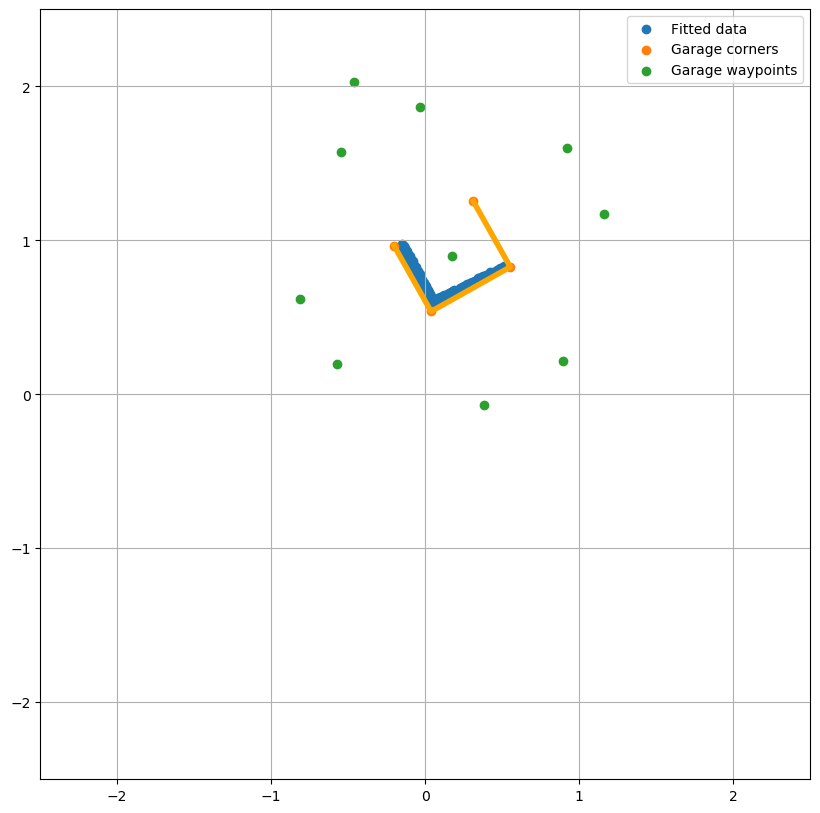

In [8]:
plot_fitted_garage(result.garage, data)

In [9]:
print(result.garage.corners)

np.linalg.norm(result.garage.corners, axis = 0)

[[ 0.03784339  0.55214349 -0.20228045  0.31201966]
 [ 0.53761304  0.82674174  0.96474363  1.25387233]]


array([0.53894332, 0.99416514, 0.98572189, 1.29211148])

In [10]:
def visualize_data(points):
    fig = plt.figure(figsize = (5,5))
    ax = fig.add_subplot(111)
    
    points = np.array(points)
    
    ax.scatter(points[0,:], points[1,:])
    
    
    # Add legend and grid
    ax.grid(True)
    ax.set_aspect("equal")
    ax.set(xlim = (-3,3), ylim = (-3,3))
    plt.show()

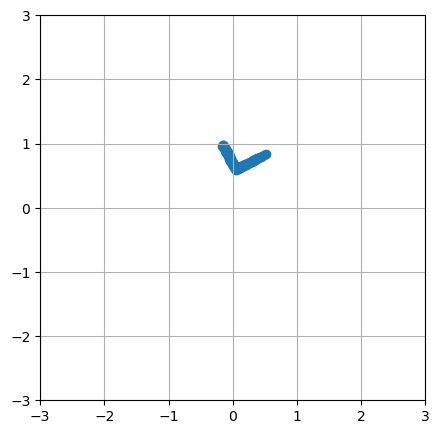

In [11]:
visualize_data(data)

In [12]:
turtle = Turtlebot(rgb = True, pc = True, depth=False)
turtle_controller = TurtlebotController(turtle, rate = 40)
turtle_controller.reset_odometry()

def kuba2kuba(point):
    return np.array([point[1], -point[0]])

In [25]:
point_to_go, idx = result.garage.closest_waypoint(2)

In [26]:
point_to_go = kuba2kuba(point_to_go)

print(point_to_go)

[2.02458782 0.45968147]


In [27]:
turtle_controller.move_to(point_to_go)

shutdown request: [/turtlenode] Reason: new node registered with same name


In [27]:
turtle_controller.get_odometry()

(array([-0.19657363,  0.37302364]), 2.0338321773489922)

In [26]:
turtle_controller.move_forward(0.2)

In [9]:
turtle_controller.rotate(1.771524768176531, relative = True)

shutdown request: [/turtlenode] Reason: new node registered with same name


In [8]:
turtle_controller.move_forward(0.7213686601776583)